<a href="https://colab.research.google.com/github/namratabhaumik/Syn_MRGE/blob/master/Synthetic_Medical_Record_Generation_Engine_(Syn_MRGE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy pandas scikit-learn tqdm kagglehub

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter

# --- 1. CONFIGURATION ---
# Define the device and model/data parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000            # Total number of diffusion steps
BETA_START = 1e-4
BETA_END = 0.02
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 100

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
DATA_FILE_PATH = os.path.join(DATA_DIR, 'parkinsons_data.csv')

# --- 2. KAGGLE DATA INGESTION ---

def download_parkinsons_data(file_path):
    """Downloads the Parkinson's dataset using the Kaggle API."""
    print("Attempting to download Parkinson's dataset via KaggleHub...")

    # You must have your Kaggle API key set up in the Colab secrets/environment
    # The dataset_load call will fail if the key is not configured.
    try:
        df = kagglehub.dataset_load(
          KaggleDatasetAdapter.PANDAS,
          "rishidamarla/parkinsons-telemonitoring-data",
          "telemonitoring_parkinsons_updrs.data.csv" # Name of the file inside the dataset
        )
        print(f"Successfully loaded data. Initial shape: {df.shape}")

        # Save to local file system for consistent loading in next step
        df.to_csv(file_path, index=False)
        return df
    except Exception as e:
        print(f"ERROR loading from KaggleHub. Ensure your Kaggle API key is configured. Error: {e}")
        # Create a dummy DataFrame to proceed if Kaggle download fails
        return pd.DataFrame()

# --- 3. EXECUTE INGESTION ---
df_raw = download_parkinsons_data(DATA_FILE_PATH)

Attempting to download Parkinson's dataset via KaggleHub...


100%|██████████| 890k/890k [00:01<00:00, 674kB/s]


Successfully loaded data. Initial shape: (5875, 22)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter

# --- 1. CONFIGURATION ---
# Define the device and model/data parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000            # Total number of diffusion steps
BETA_START = 1e-4
BETA_END = 0.02
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 100

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
DATA_FILE_PATH = os.path.join(DATA_DIR, 'parkinsons_data.csv')

# --- 2. KAGGLE DATA INGESTION ---

def download_parkinsons_data(file_path):
    """Downloads the Parkinson's dataset using the Kaggle API."""
    print("Attempting to download Parkinson's dataset via KaggleHub...")

    # You must have your Kaggle API key set up in the Colab secrets/environment
    # The dataset_load call will fail if the key is not configured.
    try:
        df = kagglehub.dataset_load(
          KaggleDatasetAdapter.PANDAS,
          "rishidamarla/parkinsons-telemonitoring-data",
          "telemonitoring_parkinsons_updrs.data.csv" # Name of the file inside the dataset
        )
        print(f"Successfully loaded data. Initial shape: {df.shape}")

        # Save to local file system for consistent loading in next step
        df.to_csv(file_path, index=False)
        return df
    except Exception as e:
        print(f"ERROR loading from KaggleHub. Ensure your Kaggle API key is configured. Error: {e}")
        # Create a dummy DataFrame to proceed if Kaggle download fails
        return pd.DataFrame()

# --- 3. EXECUTE INGESTION ---
df_raw = download_parkinsons_data(DATA_FILE_PATH)

# --- 4. PREPROCESSING AND FEATURE ENGINEERING ---

def apply_preprocessing_pipeline(df):

    # 1. Initial Cleanup: Drop ID and redundant time columns
    df.drop(columns=['subject#', 'test_time'], inplace=True, errors='ignore')

    # 2. Rename for Simplicity/Consistency
    df.rename(columns={'motor_UPDRS': 'Motor_Score', 'total_UPDRS': 'Total_Score'}, inplace=True)

    # 3. Handle Missing Values: Simple drop-na for prototype (assuming minimal NaNs)
    df.dropna(inplace=True)

    # 4. Feature Engineering: Log-Transform (Addressing Skew)
    # Jitter/Shimmer features are often highly skewed, so log-transforming them
    log_transform_cols = ['Motor_Score', 'Total_Score', 'Jitter(%)', 'Shimmer', 'NHR']

    for col in log_transform_cols:
        if col in df.columns:
            # We use log1p (log(1+x)) to handle values close to zero safely
            df[f'log_{col}'] = np.log1p(df[col])
            df.drop(columns=[col], inplace=True)

    # Define the final numerical features to be scaled. This should include ALL remaining columns.
    # The previous definition was selecting only a subset.
    numerical_cols_to_scale = df.columns.tolist()

    # 5. Feature Scaling (MinMaxScaler)
    scaler = MinMaxScaler()
    df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])

    print(f"\nProcessed Data Shape: {df.shape}")
    print(f"Total Features for Model: {df.shape[1]}")
    print("\nPreprocessed Data Head (Scaled):")
    print(df.head())

    return df, scaler

# Execute Preprocessing
df_processed, scaler = apply_preprocessing_pipeline(df_raw.copy())

# --- 5. TRAIN/VAL/TEST SPLIT AND SAVE ---

df_train, df_temp = train_test_split(df_processed, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train.to_csv(os.path.join(DATA_DIR, 'parkinsons_train.csv'))
df_val.to_csv(os.path.join(DATA_DIR, 'parkinsons_val.csv'))
df_test.to_csv(os.path.join(DATA_DIR, 'parkinsons_test.csv'))

N_FEATURES = df_train.shape[1]
print(f"N_FEATURES set to {N_FEATURES}")

Attempting to download Parkinson's dataset via KaggleHub...
Using Colab cache for faster access to the 'parkinsons-telemonitoring-data' dataset.
Successfully loaded data. Initial shape: (5875, 22)

Processed Data Shape: (5875, 20)
Total Features for Model: 20

Preprocessed Data Head (Scaled):
        age  sex  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  Jitter:DDP  \
0  0.734694  0.0     0.071164    0.064324     0.039635    0.064433   
1  0.734694  0.0     0.032819    0.017305     0.015478    0.017303   
2  0.734694  0.0     0.050458    0.030065     0.023868    0.030178   
3  0.734694  0.0     0.054856    0.027618     0.031969    0.027673   
4  0.734694  0.0     0.040353    0.010488     0.012585    0.010486   

   Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA  \
0     0.098030      0.079287      0.067543       0.051764     0.079267   
1     0.073522      0.051720      0.053186       0.052753     0.051699   
2     0.074483      0.035577      0.039375       0.044291     0

In [ ]:
# --- 3. DENOISING NETWORK ---
class MLPDenoiseModel(nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) for the Denoising Network.
    This serves the same role as the U-Net in image diffusion, but for tabular data.
    Output is the predicted noise (same shape as input)
    """
    def __init__(self, input_dim, hidden_dim, t_emb_dim=128):
        super().__init__()

        self.time_emb = nn.Sequential(
            nn.Linear(1, t_emb_dim),
            nn.SiLU(),
            nn.Linear(t_emb_dim, t_emb_dim)
        )

        # Simple MLP structure
        self.main_layers = nn.Sequential(
            nn.Linear(input_dim + t_emb_dim, hidden_dim), # Concatenate data and time embedding
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        """
        x: The noisy input data (x_t)
        t: The current timestep (for conditioning)
        """
        # Time embedding (t is a scalar, so we reshape it)
        t_embed = self.time_emb(t.float().unsqueeze(-1))

        # Concatenate x and the time embedding
        x_t_cond = torch.cat((x, t_embed), dim=-1)

        return self.main_layers(x_t_cond)

In [ ]:
# --- 4. THE DIFFUSION MODEL ---
class TabularDDPM:
    """Implements the forward (noise) and reverse (sampling) diffusion process."""
    def __init__(self, model, T, beta_start, beta_end, device):
        self.model = model.to(device)
        self.T = T
        self.device = device

        # 1. Noise Schedule (Linear schedule is a common, stable choice)
        betas = torch.linspace(beta_start, beta_end, T, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0) # Alpha-bar (used for forward process)

        # Save as buffers (not parameters)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

        # Variables for the reverse/sampling process (we will use DDPM's noise prediction)
        self.register_buffer('sqrt_recip_alphas', torch.sqrt(1.0 / alphas))
        self.register_buffer('post_variance', betas * (1. - alphas_cumprod.roll(1).clamp(min=1e-20)) / (1. - alphas_cumprod))

    def register_buffer(self, name, tensor):
        # A simple helper to store tensors in the class, sent to the correct device
        setattr(self, name, tensor)

    def forward_process(self, x_0, t):
        """
        Calculates x_t from x_0 for a given time t (The reparameterization trick)
        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
        """
        t_index = t - 1

        mean = self.sqrt_alphas_cumprod[t_index].view(-1, 1) * x_0
        std = self.sqrt_one_minus_alphas_cumprod[t_index].view(-1, 1)

        # The noise (epsilon)
        noise = torch.randn_like(x_0).to(self.device)

        x_t = mean + std * noise

        return x_t, noise # Return noisy data and the ground-truth noise

    @torch.no_grad()
    def sample(self, n_samples):
        """
        Generates synthetic data by running the reverse diffusion process T times.
        """
        # Start from pure noise (x_T)
        x_t = torch.randn(n_samples, self.model.main_layers[-1].out_features, device=self.device)

        for t in tqdm(range(self.T, 0, -1), desc="Sampling"):
            t_tensor = torch.full((n_samples, ), t, dtype=torch.long, device=self.device)
            t_index = t - 1

            # Get model's noise prediction (epsilon_theta)
            epsilon_theta = self.model(x_t, t_tensor)

            # Extract terms for the reverse step calculation
            alpha_t = self.betas[t_index] / (1.0 - self.alphas_cumprod[t_index])
            alpha_bar_t = self.alphas_cumprod[t_index]

            # Simplified DDPM reverse step (x_{t-1})
            # This is the core reverse calculation (Denoising step)
            mean = (self.sqrt_recip_alphas[t_index] *
                    (x_t - self.betas[t_index] / self.sqrt_one_minus_alphas_cumprod[t_index] * epsilon_theta))

            # Add Gaussian noise for the stochastic part, except at t=1
            if t > 1:
                z = torch.randn_like(x_t)
                x_t = mean + torch.sqrt(self.post_variance[t_index]) * z
            else:
                x_t = mean # No noise added in the final step

        return x_t.cpu() # Return to CPU for processing

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Data path (assuming the previous script ran and saved files in a 'data' folder)
DATA_PATH_TRAIN = 'data/parkinsons_train.csv'

# Diffusion Model Hyperparameters
T = 1000            # Total number of diffusion steps (noise schedule length)
BETA_START = 1e-4   # Starting beta (noise level)
BETA_END = 0.02     # Ending beta

# Training Hyperparameters
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 100 # Keep low for a quick prototype, then increase if time allows
SAVE_DIR = '/content/drive/MyDrive/Syn_MRGE/models' # Change if not using Drive
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 2. DATASET AND LOADER ---
class TabularDataset(Dataset):
    def __init__(self, data_path):
        # Load processed data and drop the Patient ID column
        df = pd.read_csv(data_path, index_col=0)

        # Convert boolean columns to integer (0 or 1) as PyTorch does not support boolean tensors directly
        for col in df.select_dtypes(include='bool').columns:
            df[col] = df[col].astype(int)

        self.data = torch.tensor(df.values, dtype=torch.float32)
        self.n_features = self.data.shape[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load dataset and create loader
train_dataset = TabularDataset(DATA_PATH_TRAIN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
N_FEATURES = train_dataset.n_features
print(f"Dataset loaded. Number of features: {N_FEATURES}")

Using device: cuda
Dataset loaded. Number of features: 20


In [ ]:
# --- 5. TRAINING LOOP AND EXECUTION ---

# 1. Model Initialization
denoise_model = MLPDenoiseModel(
    input_dim=N_FEATURES,
    hidden_dim=256,
    t_emb_dim=128
).to(DEVICE)

ddpm = TabularDDPM(
    model=denoise_model,
    T=T,
    beta_start=BETA_START,
    beta_end=BETA_END,
    device=DEVICE
)

# 2. Training Configuration
optimizer = torch.optim.Adam(ddpm.model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# 3. Training Loop
print(f"\nStarting training on {DEVICE} for {EPOCHS} epochs...")
global_step = 0
best_loss = float('inf')

for epoch in range(EPOCHS):
    ddpm.model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    epoch_loss = 0.0

    for batch in pbar:
        x_0 = batch.to(DEVICE)

        # Sample time step t uniformly from 1 to T
        t = torch.randint(1, T + 1, (x_0.shape[0],), device=DEVICE)

        # Forward process: Get noisy data (x_t) and true noise (epsilon)
        x_t, true_noise = ddpm.forward_process(x_0, t)

        # Model prediction: Predict the noise from x_t
        predicted_noise = ddpm.model(x_t, t)

        # Loss: Compare predicted noise with true noise (L_simple)
        loss = loss_fn(predicted_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        epoch_loss += loss.item()
        pbar.set_postfix({'Loss': f'{loss.item():.5f}'})

    avg_loss = epoch_loss / len(train_loader)

    # 4. Checkpointing Strategy
    if avg_loss < best_loss:
        best_loss = avg_loss
        checkpoint_path = os.path.join(SAVE_DIR, f"ddpm_best_checkpoint.pt")
        torch.save(ddpm.model.state_dict(), checkpoint_path)
        print(f"\nEpoch {epoch+1}: Model saved to {checkpoint_path} with loss {avg_loss:.5f}")

    print(f"Epoch {epoch+1} finished. Average Loss: {avg_loss:.5f}")

print("\n--- Training Complete ---")


Starting training on cuda for 100 epochs...


Epoch 1/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 1: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 6.65130
Epoch 1 finished. Average Loss: 6.65130


Epoch 2/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 2: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 1.00582
Epoch 2 finished. Average Loss: 1.00582


Epoch 3/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 3: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 0.99653
Epoch 3 finished. Average Loss: 0.99653


Epoch 4/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4 finished. Average Loss: 0.99933


Epoch 5/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 5: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 0.99314
Epoch 5 finished. Average Loss: 0.99314


Epoch 6/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 6: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 0.99118
Epoch 6 finished. Average Loss: 0.99118


Epoch 7/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 7: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 0.98992
Epoch 7 finished. Average Loss: 0.98992


Epoch 8/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8 finished. Average Loss: 1.00429


Epoch 9/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9 finished. Average Loss: 1.00601


Epoch 10/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10 finished. Average Loss: 1.00005


Epoch 11/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11 finished. Average Loss: 0.99943


Epoch 12/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12 finished. Average Loss: 0.99510


Epoch 13/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13 finished. Average Loss: 1.00047


Epoch 14/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14 finished. Average Loss: 0.99616


Epoch 15/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15 finished. Average Loss: 1.00133


Epoch 16/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16 finished. Average Loss: 1.01092


Epoch 17/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17 finished. Average Loss: 1.00165


Epoch 18/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18 finished. Average Loss: 1.00330


Epoch 19/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19 finished. Average Loss: 1.00349


Epoch 20/100:   0%|          | 0/65 [00:00<?, ?it/s]


Epoch 20: Model saved to /content/drive/MyDrive/Syn_MRGE/models/ddpm_best_checkpoint.pt with loss 0.98694
Epoch 20 finished. Average Loss: 0.98694


Epoch 21/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21 finished. Average Loss: 0.99736


Epoch 22/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 22 finished. Average Loss: 0.99672


Epoch 23/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23 finished. Average Loss: 1.00233


Epoch 24/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24 finished. Average Loss: 1.00218


Epoch 25/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25 finished. Average Loss: 1.00585


Epoch 26/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 26 finished. Average Loss: 0.99483


Epoch 27/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27 finished. Average Loss: 0.99263


Epoch 28/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28 finished. Average Loss: 0.99640


Epoch 29/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29 finished. Average Loss: 0.99474


Epoch 30/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 30 finished. Average Loss: 0.99895


Epoch 31/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31 finished. Average Loss: 1.00006


Epoch 32/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32 finished. Average Loss: 0.99489


Epoch 33/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33 finished. Average Loss: 1.00252


Epoch 34/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 34 finished. Average Loss: 1.00784


Epoch 35/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35 finished. Average Loss: 0.99715


Epoch 36/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 36 finished. Average Loss: 1.00713


Epoch 37/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 37 finished. Average Loss: 1.00199


Epoch 38/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 38 finished. Average Loss: 0.99836


Epoch 39/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 39 finished. Average Loss: 0.99500


Epoch 40/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 40 finished. Average Loss: 0.99352


Epoch 41/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 41 finished. Average Loss: 0.99968


Epoch 42/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 42 finished. Average Loss: 1.00429


Epoch 43/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 43 finished. Average Loss: 0.99307


Epoch 44/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 44 finished. Average Loss: 1.00416


Epoch 45/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 45 finished. Average Loss: 1.00082


Epoch 46/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 46 finished. Average Loss: 0.99769


Epoch 47/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 47 finished. Average Loss: 0.99516


Epoch 48/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 48 finished. Average Loss: 0.98923


Epoch 49/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 49 finished. Average Loss: 1.00179


Epoch 50/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 50 finished. Average Loss: 1.00176


Epoch 51/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 51 finished. Average Loss: 1.00509


Epoch 52/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 52 finished. Average Loss: 1.00146


Epoch 53/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 53 finished. Average Loss: 1.00231


Epoch 54/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 54 finished. Average Loss: 1.00282


Epoch 55/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 55 finished. Average Loss: 0.98990


Epoch 56/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 56 finished. Average Loss: 0.99191


Epoch 57/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 57 finished. Average Loss: 0.99814


Epoch 58/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 58 finished. Average Loss: 1.00330


Epoch 59/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 59 finished. Average Loss: 1.00485


Epoch 60/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 60 finished. Average Loss: 1.00269


Epoch 61/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 61 finished. Average Loss: 1.00260


Epoch 62/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 62 finished. Average Loss: 1.00575


Epoch 63/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 63 finished. Average Loss: 1.00727


Epoch 64/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 64 finished. Average Loss: 1.00521


Epoch 65/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 65 finished. Average Loss: 1.00149


Epoch 66/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 66 finished. Average Loss: 1.66324


Epoch 67/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 67 finished. Average Loss: 1.00913


Epoch 68/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 68 finished. Average Loss: 1.00193


Epoch 69/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 69 finished. Average Loss: 0.99865


Epoch 70/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 70 finished. Average Loss: 1.00408


Epoch 71/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 71 finished. Average Loss: 0.99510


Epoch 72/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 72 finished. Average Loss: 1.00199


Epoch 73/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 73 finished. Average Loss: 1.22190


Epoch 74/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 74 finished. Average Loss: 0.98889


Epoch 75/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 75 finished. Average Loss: 0.99695


Epoch 76/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 76 finished. Average Loss: 0.99740


Epoch 77/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 77 finished. Average Loss: 1.00040


Epoch 78/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 78 finished. Average Loss: 0.99654


Epoch 79/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 79 finished. Average Loss: 0.99375


Epoch 80/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 80 finished. Average Loss: 1.00690


Epoch 81/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 81 finished. Average Loss: 0.99530


Epoch 82/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 82 finished. Average Loss: 0.99898


Epoch 83/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 83 finished. Average Loss: 0.99227


Epoch 84/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 84 finished. Average Loss: 1.00135


Epoch 85/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 85 finished. Average Loss: 0.99142


Epoch 86/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 86 finished. Average Loss: 0.99783


Epoch 87/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 87 finished. Average Loss: 0.99958


Epoch 88/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 88 finished. Average Loss: 0.99511


Epoch 89/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 89 finished. Average Loss: 1.00237


Epoch 90/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 90 finished. Average Loss: 1.01345


Epoch 91/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 91 finished. Average Loss: 0.98755


Epoch 92/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 92 finished. Average Loss: 1.00043


Epoch 93/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 93 finished. Average Loss: 0.99805


Epoch 94/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 94 finished. Average Loss: 1.00495


Epoch 95/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 95 finished. Average Loss: 0.99979


Epoch 96/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 96 finished. Average Loss: 1.00146


Epoch 97/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 97 finished. Average Loss: 0.99790


Epoch 98/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 98 finished. Average Loss: 0.99959


Epoch 99/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 99 finished. Average Loss: 1.00515


Epoch 100/100:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 100 finished. Average Loss: 0.99865

--- Training Complete ---


In [ ]:
# --- 7. GENERATION AND INVERSE TRANSFORMATION ---

# Define the inverse transformation function (copied from previous)
def inverse_transform_data_parkinsons(df_scaled, scaler):
    """Inverse scales and inverse log-transforms the numerical Parkinson's data."""

    df_inv = df_scaled.copy()

    # 0. CRITICAL FIX: CLIP THE SCALED DATA TO A SAFE RANGE
    # DDPM output, in theory, is in [0, 1], but numerical errors can push it out.
    # Clipping ensures the expm1 (inverse log) function does not overflow.
    df_inv = df_inv.clip(lower=-0.1, upper=1.1)

    # Find all columns that were numerically scaled
    numerical_cols = df_scaled.columns.tolist()

    # 1. Inverse Scaling
    df_inv[numerical_cols] = scaler.inverse_transform(df_inv[numerical_cols])

    # 2. Inverse Log-transform (Restoring original values)
    log_cols = [col for col in df_inv.columns if col.startswith('log_')]
    for col in log_cols:
        original_col_name = col.replace('log_', '')
        # Inverse log1p is expm1 (e^x - 1)
        df_inv[original_col_name] = np.expm1(df_inv[col])
        df_inv.drop(columns=[col], inplace=True)

    # 3. Clipping/Rounding (Ensure realism, e.g., scores > 0)
    for col in df_inv.columns:
        if col not in ['sex']: # Skip binary/gender column
             df_inv[col] = df_inv[col].clip(lower=0.0).round(4) # Clip non-physical values and round to 4 decimals

    return df_inv

# --- GENERATION EXECUTION ---

# Data paths
DATA_PATH_TEST = os.path.join(DATA_DIR, 'parkinsons_test.csv')

# Load the test set (unseen real data)
df_test_scaled = pd.read_csv(DATA_PATH_TEST, index_col=0)


# 1. Load best model checkpoint and generate samples
# NOTE: Using the SAVE_DIR and ddpm object already in memory
checkpoint_path = os.path.join(SAVE_DIR, "ddpm_best_checkpoint.pt")

ddpm.model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
ddpm.model.eval() # Set model to evaluation mode


# 2. Generate samples
N_SAMPLES_SYNTHETIC = len(train_dataset) * 2 # Use train_dataset from the previous cell
print(f"Generating {N_SAMPLES_SYNTHETIC} synthetic samples...")

with torch.no_grad():
    synthetic_scaled = ddpm.sample(N_SAMPLES_SYNTHETIC)

# Convert to Pandas DataFrame
df_synthetic_scaled = pd.DataFrame(synthetic_scaled.numpy(), columns=df_test_scaled.columns)
print(f"Synthetic Data (Scaled) Shape: {df_synthetic_scaled.shape}")


# 3. Inverse Transform and Finalize
df_synthetic_final = inverse_transform_data_parkinsons(df_synthetic_scaled, scaler)
df_real_test_final = inverse_transform_data_parkinsons(df_test_scaled, scaler)

print("\n--- Synthetic Data (De-encoded/Inverse-Scaled) Head ---")
print(df_synthetic_final.head())

Generating 8224 synthetic samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Synthetic Data (Scaled) Shape: (8224, 20)

--- Synthetic Data (De-encoded/Inverse-Scaled) Head ---
         age  sex  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  Jitter:DDP  \
0  31.100000 -0.1       0.0000      0.0000       0.0000      0.0000   
1  89.900002  1.1       0.0005      0.0633       0.0000      0.0000   
2  31.100000 -0.1       0.0000      0.0000       0.0765      0.1898   
3  31.100000  1.1       0.0005      0.0000       0.0000      0.1898   
4  31.100000  1.1       0.0000      0.0633       0.0000      0.1898   

   Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA  \
0       0.0000        0.1788        0.0000         0.3028       0.5363   
1       0.0000        0.0000        0.1835         0.0000       0.5363   
2       2.3151        0.1788        0.1835         0.3028       0.0000   
3       0.0000        0.0000        0.0000         0.0000       0.5363   
4       0.0000        0.0000        0.0000         0.0000       0.5363   

         HNR    RPDE     DFA 


[8.1] Comparing Marginal Distributions (Numerical Features)...


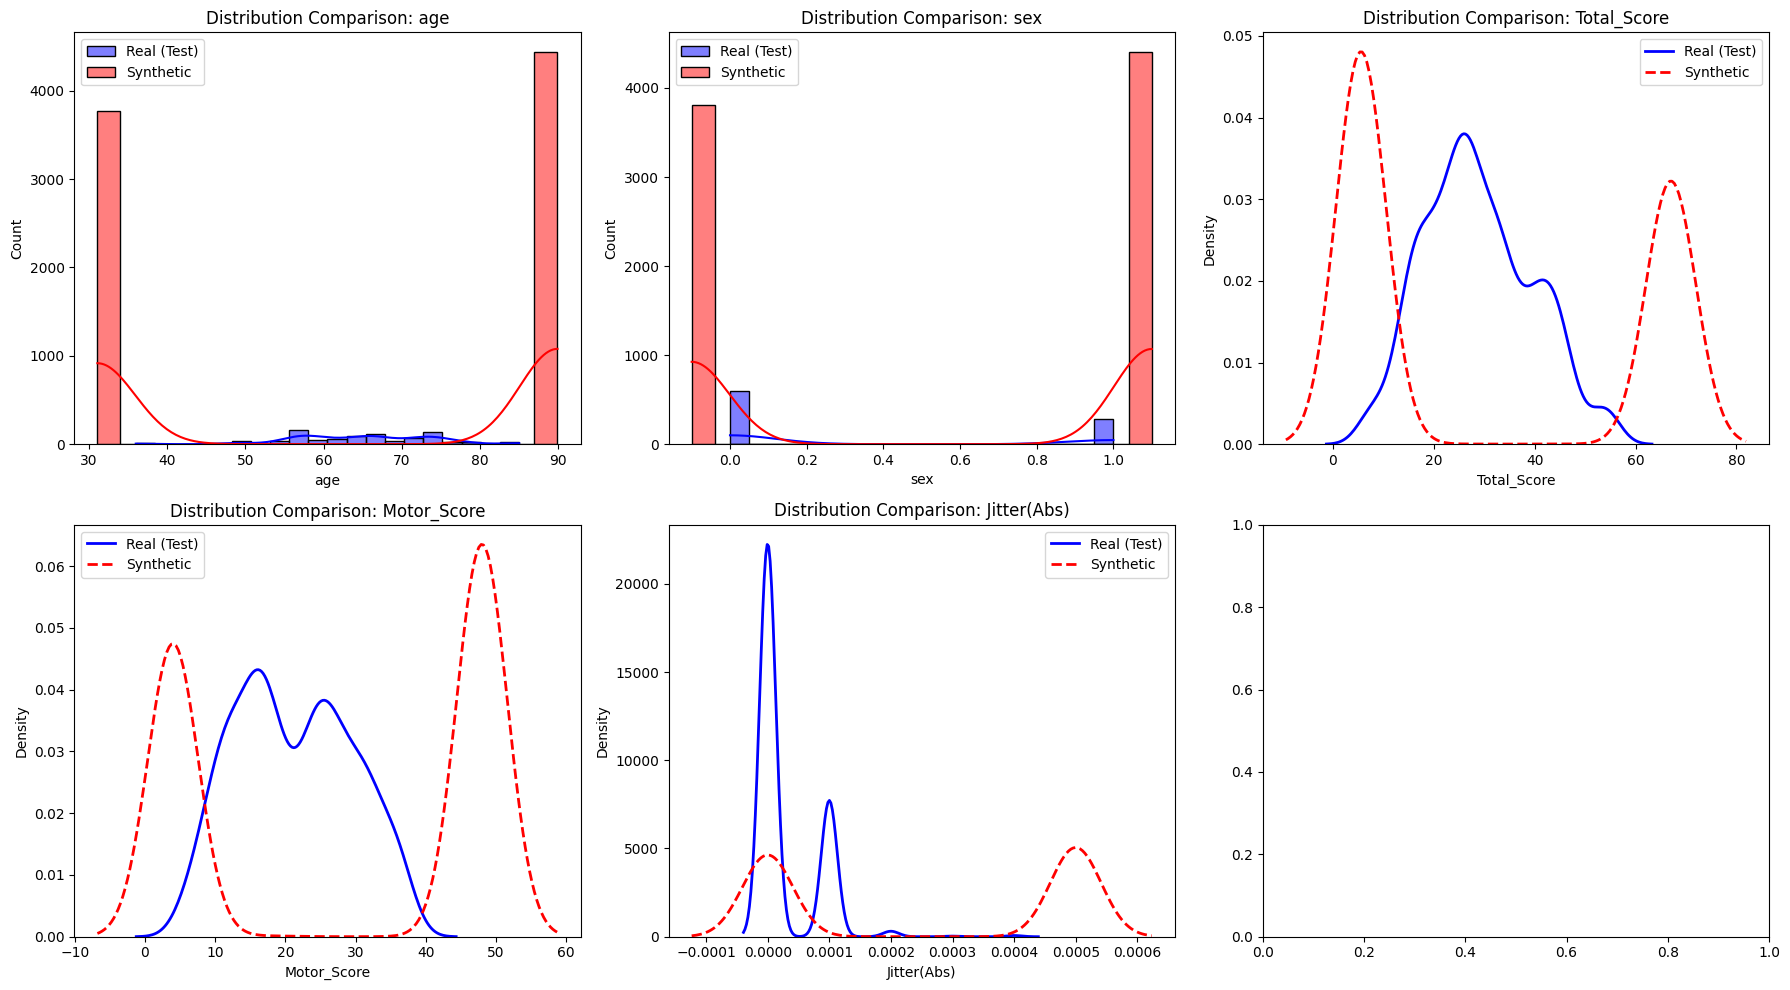


[8.1] Statistical Tests (KS-Test - p-value < 0.05 rejects H0: distributions are similar)
KS-Test for age: Stat=0.5544, P-Value=0.0000
KS-Test for sex: Stat=0.5147, P-Value=0.0000
KS-Test for Total_Score: Stat=0.6088, P-Value=0.0000
KS-Test for Motor_Score: Stat=0.5862, P-Value=0.0000
KS-Test for Jitter(Abs): Stat=0.5340, P-Value=0.0000

[8.2] Comparing Correlation Structure...


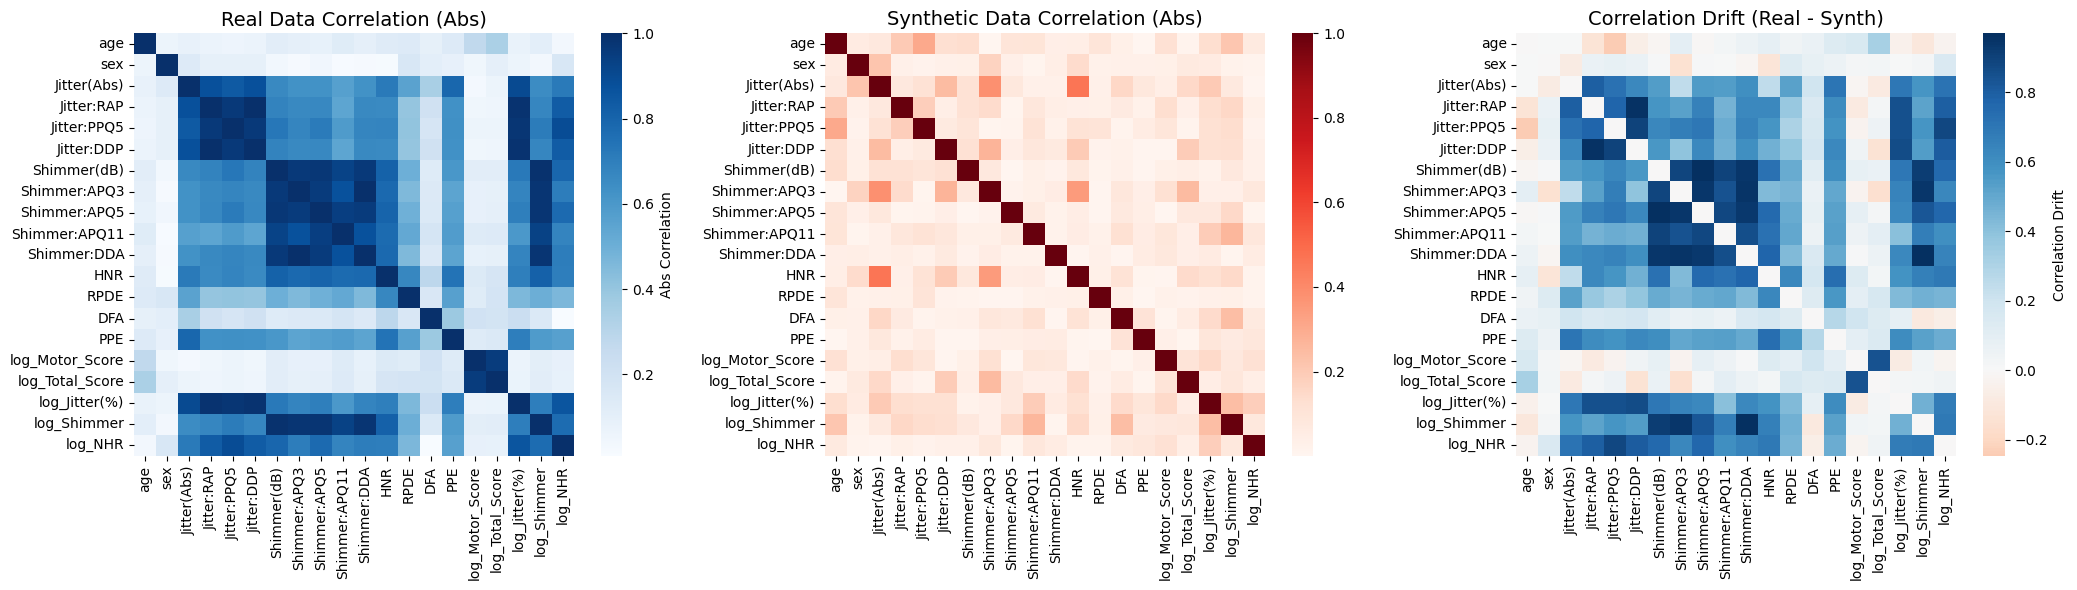


[8.3] Comparing Data in Low-Dimensional Space (UMAP)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


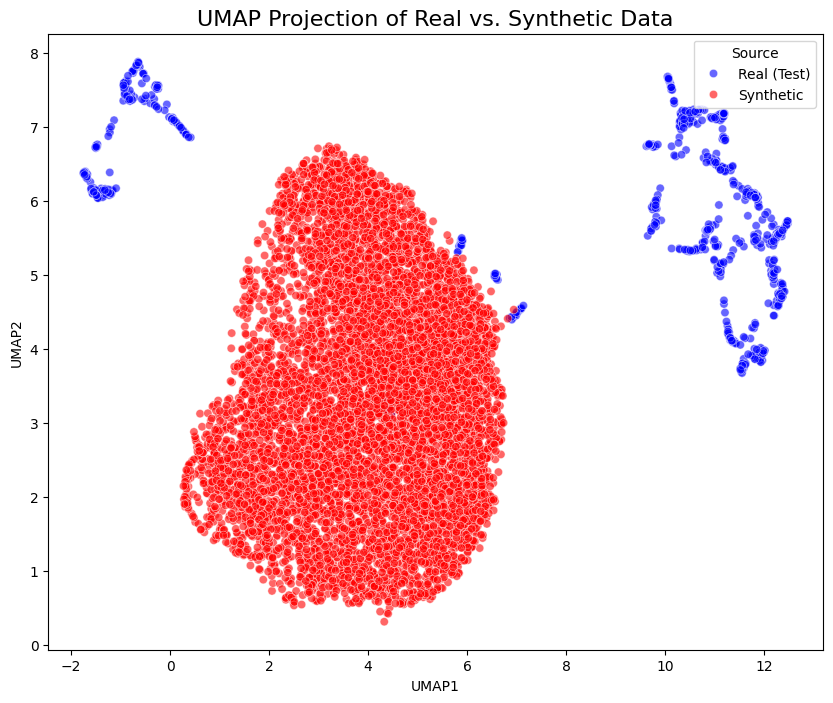

In [ ]:
# --- 8. EVALUATION & VALIDATION (Section 3.C Deliverables) ---

!pip install seaborn scikit-learn umap-learn # Re-install just in case

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
from scipy.stats import kstest

# --- 8.1. Marginal Distributions (Histograms/KDE) ---

print("\n[8.1] Comparing Marginal Distributions (Numerical Features)...")
# Select only a few key features for clear visualization (e.g., Scores and Age)
numerical_cols_final = ['age', 'sex', 'Total_Score', 'Motor_Score', 'Jitter(Abs)']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Flatten array for easy indexing

for i, col in enumerate(numerical_cols_final):
    # Use KDE for continuous data, Hist for discrete (like sex, if we kept it as 0/1)
    if col in ['sex', 'age']: # Age distribution is often simpler as a KDE/hist mix
        sns.histplot(df_real_test_final[col], bins=20, label='Real (Test)', ax=axes[i], color='blue', alpha=0.5, kde=True)
        sns.histplot(df_synthetic_final[col], bins=20, label='Synthetic', ax=axes[i], color='red', alpha=0.5, kde=True)
    else:
        sns.kdeplot(df_real_test_final[col], label='Real (Test)', ax=axes[i], color='blue', linewidth=2)
        sns.kdeplot(df_synthetic_final[col], label='Synthetic', ax=axes[i], color='red', linestyle='--', linewidth=2)

    axes[i].set_title(f'Distribution Comparison: {col}', fontsize=12)
    axes[i].legend()

plt.tight_layout()
plt.show()


# Apply Statistical Test (KS-test for numerical)
print("\n[8.1] Statistical Tests (KS-Test - p-value < 0.05 rejects H0: distributions are similar)")
for col in numerical_cols_final:
    ks_stat, p_value = kstest(df_real_test_final[col].sample(n=len(df_test_scaled), random_state=42),
                              df_synthetic_final[col].sample(n=len(df_test_scaled), random_state=42)) # Sample to match size
    print(f"KS-Test for {col}: Stat={ks_stat:.4f}, P-Value={p_value:.4f}")


# --- 8.2. Correlation Structure (Correlation Matrices) ---

print("\n[8.2] Comparing Correlation Structure...")

# Use the full scaled data (the inputs to the model) for correlation comparison
corr_real = df_test_scaled.corr().abs()
corr_synthetic = df_synthetic_scaled.corr().abs()
corr_diff = corr_real - corr_synthetic

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Plot Correlation Matrices
sns.heatmap(corr_real, annot=False, cmap='Blues', fmt=".2f", ax=axes[0], cbar_kws={'label': 'Abs Correlation'})
axes[0].set_title('Real Data Correlation (Abs)', fontsize=14)

sns.heatmap(corr_synthetic, annot=False, cmap='Reds', fmt=".2f", ax=axes[1])
axes[1].set_title('Synthetic Data Correlation (Abs)', fontsize=14)

sns.heatmap(corr_diff, annot=False, cmap='RdBu', fmt=".2f", ax=axes[2], center=0, cbar_kws={'label': 'Correlation Drift'})
axes[2].set_title('Correlation Drift (Real - Synth)', fontsize=14)

plt.tight_layout()
plt.show()


# --- 8.3. Low-Dimensional Visualization (UMAP) ---

print("\n[8.3] Comparing Data in Low-Dimensional Space (UMAP)...")

# Combine real (test) and synthetic data (scaled)
df_combined = pd.concat([df_test_scaled, df_synthetic_scaled], axis=0)

# Create labels
labels = ['Real (Test)'] * len(df_test_scaled) + ['Synthetic'] * len(df_synthetic_scaled)

# Apply UMAP
umap_2d = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings = umap_2d.fit_transform(df_combined.values)

df_umap = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
df_umap['Source'] = labels

# Visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Source',
    data=df_umap,
    alpha=0.6,
    palette={'Real (Test)': 'blue', 'Synthetic': 'red'}
)
plt.title('UMAP Projection of Real vs. Synthetic Data', fontsize=16)
plt.show()